### 목차
***
1. 데이터 준비 및 확인_[네이버 영화리뷰](https://github.com/e9t/nsmc)
2. 데이터 전처리
	1. 중복 및  결측치 처리
	2. 문장 길이 확인 (최대, 최소 길이 설정)
	3. 노이즈 데이터 확인 및 제거 (길이 1)
	4. 데이터 분포 확인
3. **SentencePiece** 모델 학습 : **model_type=unigram**
4. Tokenizer 함수 생성
5. 데이터 로더 구성
6. 모델 구성 및 validation set 구성
7. 모델 훈련
8. 모델 평가
9. 성능 비교
	1. SentencePiece 모델의 **model_type=bpe** 변경
		1. SentencePiece 모델학습
		2. Tokenizer 함수 생성
		3. 데이터 로더 구성
		4. 모델 및 validation set 구성
		5. 모델 훈련
		6. 모델 평가
	2. **KoNLPy** 형태소 분석기를 사용하여 모델 학습
		1. 데이터 로더 구성
		2. 모델 구성을 위한 데이터 가공
		3. 모델 구성 및 validation set 구성
		4. 모델 훈련
		5. 모델 평가
  
10. 회고 및 정리

In [198]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 1. 데이터 준비 및 확인

In [199]:
import pandas as pd
 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [200]:
train_data.shape

(150000, 3)

## 2. 데이터 전처리
- 중복 및 결측치 처리
- 문장 길이 확인 (최대 최소 평균)
- 노이즈 데이터 제거 : 길이1인 문장 확인 등
- 문장 분포 확인

### 1 중복 및 null 값 처리

In [201]:
# 중복 및 null 값 처리
train_data[train_data['document'].isnull()]
test_data[test_data['document'].isnull()]
train_data.isna().sum()

id          0
document    5
label       0
dtype: int64

In [202]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how='any')
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how='any')

In [203]:
print(train_data.isna().sum())
print(test_data.isna().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


### 2 문장 길이 확인

In [204]:
# 전체 문장 리스트로 만들어 raw corpus 만들기
raw = list(train_data['document'])+list(test_data['document'])
type(raw)
len(raw)

195339

Data Size: 195339
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/tmp/ipykernel_13/2013385127.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


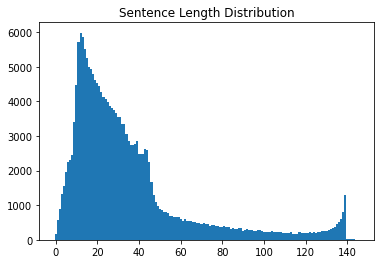

In [205]:
min_len = 999
max_len = 0
sum_len = 0

print('Data Size:', len(raw))

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print('문장의 최단 길이:', min_len)
print('문장의 최장 길이:', max_len)
print('문장의 평균 길이:', sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

### 3 노이즈 데이터 확인 및 제거
문장의 최단길이를 확인하기 위해 함수를 이용해 확인한다. 

In [206]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return
            
check_sentence_with_length(raw, 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


길이가 1인 문장은 버려도 될 것 같다. 다만 2부터는 굳굳, 최고 등 감성분석에 필요한 단어들이 들어가있으므로 제거하지 않는다.

/tmp/ipykernel_13/4196487287.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


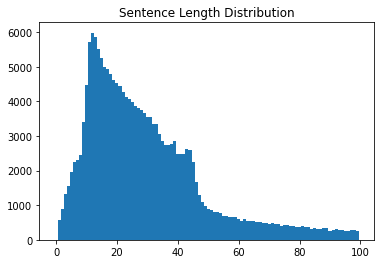

In [207]:
max_len = 100
min_len = 2

# 길이 조건에 맞는 문장만 선택한다.
filtered_corpus = [s for s in raw if (len(s) <= max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려본다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

## 3. SentencePiece 모델 학습
토큰화를 위한 모델

In [208]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME') + '/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 6000

with open(temp_file, 'w') as f:
    for row in filtered_corpus: # 이전 스텝에서 정제했던 corpus 활용
        f.write(str(row) + '\n')
        
spm.SentencePieceTrainer.Train('--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size))

# 위 Train에서 --model_type = 'unigram'이 디폴트 적용되어 있다.
# --model_type = 'bpe' 로 옵션을 주어 변경할 수 있다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 336404 Mar 23 07:14 korean_spm.model
-rw-r--r-- 1 root root 104063 Mar 23 07:14 korean_spm.vocab


#### 모델 불러오기

In [209]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

In [210]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs) # 아이디로 토크나이즈

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.', 1, 0.0))
# 문자열에 대해 토크나이즈

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))
# 아이디를 통해 디코딩

[1682, 9, 321, 15, 1445, 9, 104, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## 4. Tokenizer 함수 생성
위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의한다.  
하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵다.  
따라서 아래 조건을 만족하는 함수를 정의한다.
>1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 **온전한 문장**의 list를 전달한다.  
>2) **생성된 vocab 파일**을 읽어와 { <word\> : <idx\> } 형태를 가지는 word_index 사전과 { <idx\> : <word\> } 형태를 가지는 index_word 사전을 생성하고 함께 반환한다.  
>3) 리턴값인 tensor는 앞의 함수와 동일하게 토큰화한 후 Encoding 된 문장이다. 바로 학습에 사용할 수 있게 padding도 수행한다.

In [211]:
def sp_tokenize(s, corpus):
    
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen)) # 아이디로 문장 토큰화된 값 추가
        
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        
        word_index.update({word:idx})
        index_word.update({idx:word})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=100)
    
    return tensor, word_index, index_word

In [212]:
# sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']

tensor, word_index, index_word = sp_tokenize(s, my_corpus)
#print(tensor)

In [213]:
#word_index
#index_word

## 5. 데이터 로더 구성

In [214]:
#num_words = 8000

def load_data(train_data, test_data):
    
    # 토큰화 및 불용어 제거
    X_train, word_index, index_word = sp_tokenize(s, list(train_data['document']))
    
    X_test, _, _ = sp_tokenize(s, list(test_data['document']))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_index, index_word

In [215]:
X_train, y_train, X_test, y_test, word_index, index_word = load_data(train_data, test_data)

sp_tokenize에서 padding한 값을 리턴하니까 따로 padding을 수행하진 않는다.

## 6. 모델 구성 및 validation set 구성

In [227]:
# sp_tokenize를 이용한 모델
vocab_size = 6000
word_vector_dim = 16

model_sp = tf.keras.Sequential()
model_sp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_sp.add(tf.keras.layers.LSTM(8))
model_sp.add(tf.keras.layers.Dense(8, activation='relu'))
model_sp.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_sp.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 16)          96000     
_________________________________________________________________
lstm_14 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 96,881
Trainable params: 96,881
Non-trainable params: 0
_________________________________________________________________


In [228]:
# validation set 구성
x_val = X_train[:30000]
y_val = y_train[:30000]

# 나머지
partial_x_train = X_train[30000:]
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)

(116182, 100)
(116182,)
(30000, 100)


## 7. 모델 훈련

In [229]:
epochs = 20

model_sp.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model_sp.fit(partial_x_train,
                      partial_y_train,
                      epochs=epochs,
                      batch_size = 256,
                      validation_data=(x_val, y_val),
                      verbose=1)

Epoch 1/20
454/454 [==============================] - 5s 8ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 2/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6931 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 3/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6639 - accuracy: 0.5827 - val_loss: 0.6354 - val_accuracy: 0.6715
Epoch 4/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6404 - accuracy: 0.6424 - val_loss: 0.6579 - val_accuracy: 0.5878
Epoch 5/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6522 - accuracy: 0.6008 - val_loss: 0.6506 - val_accuracy: 0.6075
Epoch 6/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6473 - accuracy: 0.6146 - val_loss: 0.6482 - val_accuracy: 0.6147
Epoch 7/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6277 - accuracy: 0.6759 - val_loss: 0.6251 - val_accuracy: 0.6746
Epoch 

## 8. 모델 평가

In [230]:
results_sp = model_sp.evaluate(X_test, y_test, verbose=2)
print('-----<sp_tokenizer를 사용한 모델>-----: \n', results_sp)

1537/1537 - 4s - loss: 0.6198 - accuracy: 0.6640
-----<sp_tokenizer를 사용한 모델>-----: 
 [0.61982262134552, 0.6640356183052063]


초반에 모델 돌렸을 때 정확도가 83 정도 나왔었는데, 아래 bpe 돌리고 난 뒤 다시 돌려보니 그 정도의 성능은 안나온다.. 

맨 처음엔 SentencePiece 모델 학습할 때부터 vocab_size를 8000으로 두고 시작했는데, 6000정도로 사이즈를 줄이니 성능이 더 좋게 나오는 것 같다. 

따라서 아래에 성능 비교할 때 vocab_size를 6000으로 고정한다. 

# 9. 성능 비교
- SentecePiece 모델의 model_type, vocab_size 등을 변경해가며 성능개선 여부 확인하기
- KoNLPY 형태소 분석기를 사용한 모델과 성능 비교

## 1 SentencePiece 모델의 model_type 변경
***
model_type = 'bpe'로 변경
### 1-1. SentencePiece 모델 학습

In [141]:
temp_file = os.getenv('HOME') + '/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 6000

with open(temp_file, 'w') as f:
    for row in filtered_corpus: # 이전 스텝에서 정제했던 corpus 활용
        f.write(str(row) + '\n')
        
spm.SentencePieceTrainer.Train('--input={} --model_prefix=korean_spm --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size))

# 위 Train에서 --model_type = 'unigram'이 디폴트 적용되어 있다.
# --model_type = 'bpe' 로 옵션을 주어 변경할 수 있다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=6000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: BPE
  vocab_size: 6000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_voca

-rw-r--r-- 1 root root 333295 Mar 23 06:53 korean_spm.model
-rw-r--r-- 1 root root  82501 Mar 23 06:53 korean_spm.vocab


In [142]:
# 모델 불러오기
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

In [143]:
# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.', 1, 0.0))
# 문자열에 대해 토크나이즈

['▁아', '버', '지가', '방', '에', '들어', '가', '신', '다', '.']


model_type=unigram 일 때와 토큰화된 모양이 다르다!

### 1-2. Tokenizer 함수 생성

In [144]:
def bpe_tokenize(s, corpus):
    
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen)) # 아이디로 문장 토큰화된 값 추가
        
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        
        word_index.update({word:idx})
        index_word.update({idx:word})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=100)
    
    return tensor, word_index, index_word

### 1-3. 데이터 로더 구성

In [145]:
def load_data(train_data, test_data):
    
    # 토큰화 및 불용어 제거
    X_train, word_index, index_word = bpe_tokenize(s, list(train_data['document']))
    
    X_test, _, _ = bpe_tokenize(s, list(test_data['document']))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_index, index_word

In [146]:
X_train, y_train, X_test, y_test, word_index, index_word = load_data(train_data, test_data)

### 1-4. 모델 및 validation set 구성

In [149]:
# bpe_tokenize를 이용한 모델
vocab_size = 6000
word_vector_dim = 16

model_sp = tf.keras.Sequential()
model_sp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_sp.add(tf.keras.layers.LSTM(8))
model_sp.add(tf.keras.layers.Dense(8, activation='relu'))
model_sp.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_sp.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          96000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 96,881
Trainable params: 96,881
Non-trainable params: 0
_________________________________________________________________


In [150]:
# validation set 구성
x_val = X_train[:30000]
y_val = y_train[:30000]

# 나머지
partial_x_train = X_train[30000:]
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)

(116182, 100)
(116182,)
(30000, 100)


### 1-5. 모델 훈련

In [151]:
epochs = 20

model_sp.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model_sp.fit(partial_x_train,
                      partial_y_train,
                      epochs=epochs,
                      batch_size = 256,
                      validation_data=(x_val, y_val),
                      verbose=1)

Epoch 1/20
454/454 [==============================] - 5s 8ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 2/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6934 - val_accuracy: 0.4978
Epoch 3/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5021
Epoch 4/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5021
Epoch 5/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4982
Epoch 6/20
454/454 [==============================] - 3s 7ms/step - loss: 0.6924 - accuracy: 0.5056 - val_loss: 0.6835 - val_accuracy: 0.5017
Epoch 7/20
454/454 [==============================] - 3s 7ms/step - loss: 0.5724 - accuracy: 0.7241 - val_loss: 0.5819 - val_accuracy: 0.6959
Epoch 

### 1-6. 모델 평가

In [152]:
results_sp = model_sp.evaluate(X_test, y_test, verbose=2)
print('-----<model_type=bpe 를 사용한 모델>-----: \n', results_sp)

1537/1537 - 4s - loss: 0.3668 - accuracy: 0.8434
-----<model_type=bpe 를 사용한 모델>-----: 
 [0.36681124567985535, 0.8434200882911682]


SentencePiece 모델을 학습하고 예시문장을 인코딩해봤는데, 사람의 눈으로 보기에는 단어가 띄어쓰기 형태가 model_type=unigram일 때에 비해 이해하기 어려웠다.   
하지만 모델을 돌려보니 성능은 훨씬 좋게 나온다. 

**bpe**가 기본적으로 연속으로 많이 등장한 글자의 쌍을 찾아서 하나의 글자로 병합하는 방식이다보니 좋은 성능이 나온 것 같다.  
반면 **unigram**의 경우 현재 단어의 확률만을 고려하기 때문에 깔끔하게 정돈된 글이 아닌 리뷰를 다루는 데에 있어서 성능이 그렇게 좋게 나오지 못 한 것 같다.
- https://blog.floydhub.com/tokenization-nlp/

***
## 2. KoNLPy 형태소 분석기를 사용하여 모델 학습

### 2-1. 데이터로더 구성

In [231]:
from konlpy.tag import Okt
import numpy as np
from collections import Counter

tokenizer = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    # 중복 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')
    
    # 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) #형태소토큰화
        temp_x = [word for word in temp_x if not word in stopwords]
        X_train.append(temp_x)
        
    X_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence)
        temp_x = [word for word in temp_x if not word in stopwords]
        X_test.append(temp_x)
    
    # 사전 구성 
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['','','',''] + [key for key,_ in counter]
    
    word_to_index = {word: index for index,word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [232]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [233]:
index_to_word = {index: word for word, index in word_to_index.items()}

In [234]:
word_to_index = {k:(v+3) for k, v in word_to_index.items()}

#처음 몇 개 인덱스는 사전에 정의되어 있다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2 
word_to_index["<UNUSED>"] = 3

index_to_word = {index: word for word,index in word_to_index.items()}

### 2-2. 모델 구성을 위한 데이터 가공

In [235]:
#패딩 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen = 100)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                     value=word_to_index["<PAD>"],
                                                     padding = 'pre',
                                                     maxlen=100)
print(X_train.shape)

(146182, 100)


### 2-3. 모델 구성 및 validation set 구성

In [236]:
vocab_size = 6000
word_vector_dim = 16 #워드벡터의 차원수 

#모델 설계 
model_ko = tf.keras.Sequential()
model_ko.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim, input_shape=(None, )))
model_ko.add(tf.keras.layers.LSTM(8))
model_ko.add(tf.keras.layers.Dense(8, activation='relu'))
model_ko.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_ko.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 16)          96000     
_________________________________________________________________
lstm_15 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 96,881
Trainable params: 96,881
Non-trainable params: 0
_________________________________________________________________


In [237]:
# validation set 구성
x_val = X_train[:30000]
y_val = y_train[:30000]

# 나머지
partial_x_train = X_train[30000:]
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)

(116182, 100)
(116182,)
(30000, 100)


### 2-4. 모델 훈련

In [238]:
epochs = 20

model_ko.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model_ko.fit(partial_x_train,
                      partial_y_train,
                      epochs=epochs,
                      batch_size = 256,
                      validation_data=(x_val, y_val),
                      verbose=1)

Epoch 1/20
454/454 [==============================] - 7s 9ms/step - loss: 0.4679 - accuracy: 0.7845 - val_loss: 0.3613 - val_accuracy: 0.8404
Epoch 2/20
454/454 [==============================] - 3s 7ms/step - loss: 0.3469 - accuracy: 0.8484 - val_loss: 0.3524 - val_accuracy: 0.8419
Epoch 3/20
454/454 [==============================] - 3s 7ms/step - loss: 0.3300 - accuracy: 0.8557 - val_loss: 0.3495 - val_accuracy: 0.8434
Epoch 4/20
454/454 [==============================] - 3s 7ms/step - loss: 0.3184 - accuracy: 0.8613 - val_loss: 0.3485 - val_accuracy: 0.8447
Epoch 5/20
454/454 [==============================] - 3s 7ms/step - loss: 0.3075 - accuracy: 0.8662 - val_loss: 0.3513 - val_accuracy: 0.8436
Epoch 6/20
454/454 [==============================] - 3s 7ms/step - loss: 0.2990 - accuracy: 0.8713 - val_loss: 0.3559 - val_accuracy: 0.8432
Epoch 7/20
454/454 [==============================] - 3s 7ms/step - loss: 0.2904 - accuracy: 0.8747 - val_loss: 0.3620 - val_accuracy: 0.8408
Epoch 

### 2-5. 모델 평가

In [240]:
results_ko = model_ko.evaluate(X_test, y_test, verbose=2)
print('-----<KoNLPy를 사용한 모델>-----: \n', results_ko)

1537/1537 - 4s - loss: 0.4836 - accuracy: 0.8259
-----<KoNLPy를 사용한 모델>-----: 
 [0.48361286520957947, 0.8258640766143799]


학습데이터는 정확도가 91 까지 올라간 데 비해 검증데이터의 정확도는 82 정도이다.   
***


예전부터 한글과 영어를 같이 분석하는 방식이 궁금했는데 이번에 SentencePiece를 통해 해결책을 찾은 것 같다.

프로젝트를 진행하면서 SentencePiece를 어떻게 어디서부터 활용해야할지 고민이었는데, 하다보니 방법이 나왔다. 맞는지는 모르겠다. 딥러닝 모델도 오랜만에 보니 잘 모르겠다.  

우선 데이터를 받아와서 결측치와 중복값만 처리를 해주었다.  
KoNLPy에서는 토큰화와 더불어서 불용어도 처리하고 여러가지 처리가 들어갔는데, sentencepiece는 불용어는 처리하지 않았다.  

SentencePiece 모델에도 model_type이 여러가지 있는데, 그 중에 unigram과 bpe를 적용시켜 모델을 학습시켜보았다.  

먼저 **unigram**이 적용된 spm을 단어사전 개수 8000개로 모델을 돌려보았다. 학습데이터에 대한 정확도가 계속 50% 정도에서 머물러 있어서 잘못 처리한 줄 알았다.  
단어사전이 너무 많나 싶어 **단어개수를 6000**개로 바꾸고 padding을 하는 과정에서 **max_len도 100**으로 설정을 해주었다. (원랜 140정도였고, 이게 데이터에서 가장 긴 문장길이이다.)  
다시 돌려보니 테스트 정확도가 **66%** 까지 꽤 올라갔지만 만족스럽진 않았다.

다음으로 **model_type = bpe**로 바꿔 sentencepiece를 학습시키고 데이터를 토큰화해서 딥러닝 모델을 학습시켜봤다. 위에서 단어개수 6000개가 성능이 괜찮았기에 계속 이걸로 학습시켰고, 테스트 **정확도는 84%** 에 loss는 0.36 정도로 나름 괜찮은 결과가 나왔다.

마지막으로 **KoNLPy**를 활용해서 같은 조건의 데이터(단어사전개수 6000개, maxlen=100)를 학습시켜봤다. 학습데이터의 정확도가 91% 까지 올라가길래 혹시 불용어처리를 해서 성능이 좋은 건가 싶었다. 하지만 테스트데이터의 **정확도가 82%** 정도 나와서 과적합이 의심된다.  

결과적으로 가장 좋은 성능을 보인 모델은 **SentencePiece**를 적용시킨 모델이었고 그 중에서도 model_type이 **bpe** 일 때이다.   
unigram과 bpe가 어떻게 다르길래 성능차이가 이렇게 심하게 나나 싶어 찾아본 [블로그](https://blog.floydhub.com/tokenization-nlp/). 또 읽어보자.   

간단히 정리하면 **bpe**는 기본적으로 연속으로 많이 등장한 글자의 쌍을 찾아서 하나의 글자로 병합하는 방식이다보니 좋은 성능이 나온 반면 **unigram**의 경우 현재 단어의 확률만을 고려하기 때문에 깔끔하게 정돈된 글이 아닌 리뷰를 다루는 데에 있어서 성능이 그렇게 좋게 나오지 못 한 것 같다.